In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists("CuPL"):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Flowers102(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class text features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features /= cls_name_features.norm(dim=-1, keepdim=True)

    # Fill diagonal for better visibility
    cls_name_similarity = (cls_name_features @ cls_name_features.T).fill_diagonal_(float('nan')).cpu().numpy()
    cls_name_features = cls_name_features.cpu().numpy()

In [9]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}

In [10]:
# Create template text features
with torch.no_grad():
    template_label_ids = []
    template_text_features = []
    template_cls_features = []
    for label_id, texts in template_label_texts_list.items():
        template_label_ids.append([label_id] * len(texts))
        class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        template_text_features.append(class_embeddings)
        template_cls_features.append(class_embedding)
    template_label_ids = np.hstack(template_label_ids)
    template_text_features = torch.vstack(template_text_features).cpu().numpy()
    template_cls_features = torch.stack(template_cls_features)

    # Fill diagonal for better visibility
    template_similarity = (template_cls_features @ template_cls_features.T).fill_diagonal_(float('nan')).cpu().numpy()

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts = json.load(f)

In [12]:
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [13]:
import inflect
p = inflect.engine()

# For bridging classsname in dataset with name in CuLP prompts
new_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    # Filter out texts that does not contain the class name
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split()
    )
    new_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(text.lower().replace('-', ' ').replace(',', ' ').replace('\'s', ' ').replace('–', ' ').split())]
    filtered = [text for text in texts if cls_name_set.isdisjoint(text.lower().replace('-', ' ').replace(',', ' ').replace('\'s', ' ').replace('–', ' ').split())]
    if len(filtered) != 0:
        print(f"Filtered {len(filtered)} prompts for {cls_name}")
        print(filtered)
        print()

Filtered 1 prompts for pink primrose
["I'm not sure what you are asking."]

Filtered 1 prompts for english marigold
['Look for a plant with showy, fragrant yellow, orange, or red flowers.']

Filtered 1 prompts for tiger lily
['.']

Filtered 1 prompts for globe thistle
['.']

Filtered 1 prompts for globe-flower
[' that grows naturally in Europe.']

Filtered 2 prompts for giant white arum lily
['.', '.']

Filtered 1 prompts for corn poppy
['.']

Filtered 3 prompts for prince of wales feathers
['The flower is characterized by long, narrow leaves with a silvery-white downy coating.', 'I am not sure what you are asking.', "I'm not sure what you are asking."]

Filtered 1 prompts for artichoke
[', in the wildArtichokes are thistle-like flowers that grow in clusters.']

Filtered 1 prompts for garden phlox
['.']

Filtered 1 prompts for love in the mist
['Look for a flower with a delicate, lacy appearance.']

Filtered 3 prompts for great masterwort
['.', 'Look for a plant with dark green leaves 

In [14]:
gpt3_label_texts_list = {label_id: new_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}

In [15]:
# Create gpt3 text features
with torch.no_grad():
    gpt3_label_ids = []
    gpt3_text_features = []
    gpt3_cls_features = []
    for label_id, texts in gpt3_label_texts_list.items():
        gpt3_label_ids.append([label_id] * len(texts))
        class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        gpt3_text_features.append(class_embeddings)
        gpt3_cls_features.append(class_embedding)
    gpt3_label_ids = np.hstack(gpt3_label_ids)
    gpt3_text_features = torch.vstack(gpt3_text_features).cpu().numpy()
    gpt3_cls_features = torch.stack(gpt3_cls_features)

    # Fill diagonal for better visibility
    gpt3_similarity = (gpt3_cls_features @ gpt3_cls_features.T).fill_diagonal_(float('nan')).cpu().numpy()

In [16]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-np.triu(similarity, k=1), axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f"Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}")

In [17]:
def plot_similarity(similarity, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.title(title)
    plt.show()

Class name similarity mean: 0.56787109375
Class name similarity std: 0.0955810546875
Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, Similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, Similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, Similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, Similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, Similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, Similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, Similarity: 0.8251953125


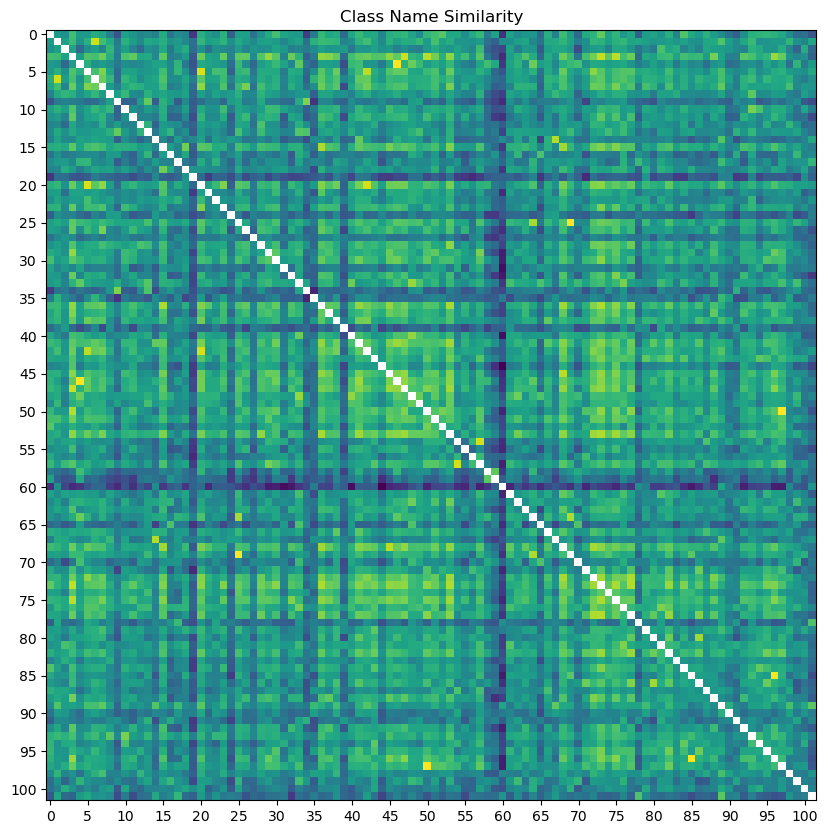

Text template similarity mean: 0.5830078125
Text template similarity std: 0.0941162109375
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, Similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, Similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, Similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, Similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, Similarity: 0.8447265625


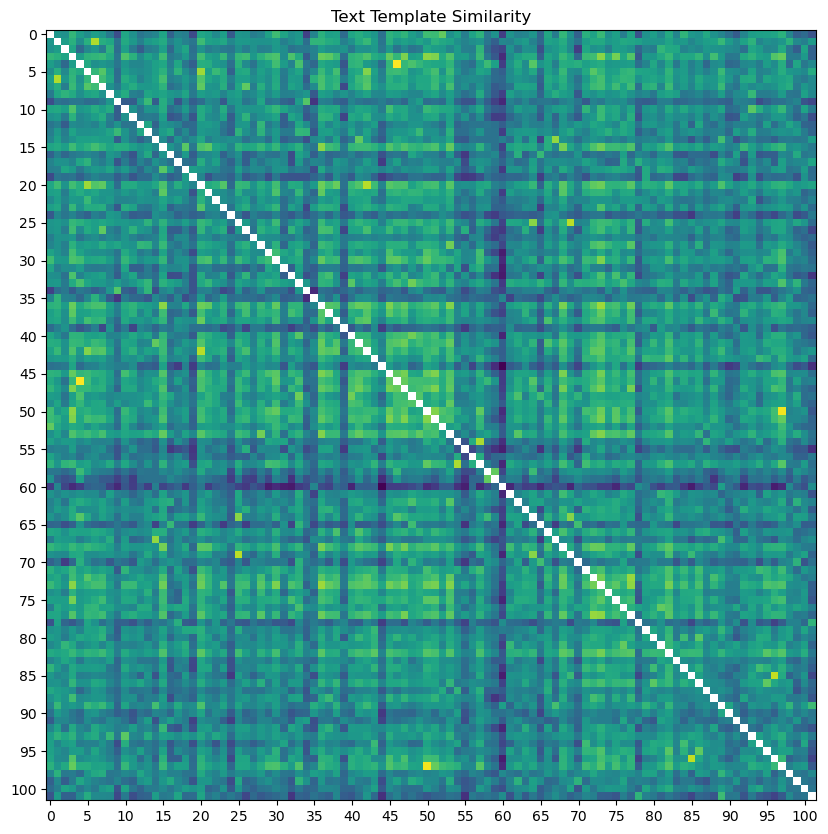

GPT-3 text similarity mean: 0.5966796875
GPT-3 text similarity std: 0.08856201171875
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.97705078125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8935546875
Rank 7: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 8: (54)pelargonium - (57)geranium, Similarity: 0.8876953125
Rank 9: (20)fire lily - (42)sword lily, Similarity: 0.8818359375
Rank 10: (5)tiger lily - (20)fire lily, Similarity: 0.880859375


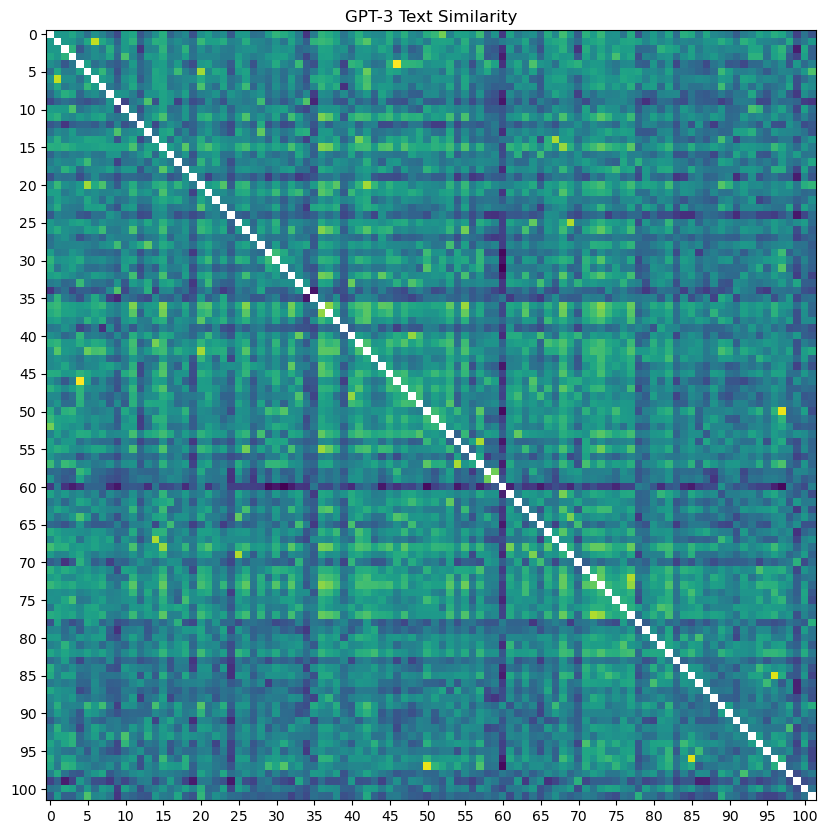

In [18]:
print(f"Class name similarity mean: {np.nanmean(cls_name_similarity)}")
print(f"Class name similarity std: {np.nanstd(cls_name_similarity)}")
print_top_similarity(cls_name_similarity)
plot_similarity(cls_name_similarity, "Class Name Similarity")
print(f"Text template similarity mean: {np.nanmean(template_similarity)}")
print(f"Text template similarity std: {np.nanstd(template_similarity)}")
print_top_similarity(template_similarity)
plot_similarity(template_similarity, "Text Template Similarity")
print(f"GPT-3 text similarity mean: {np.nanmean(gpt3_similarity)}")
print(f"GPT-3 text similarity std: {np.nanstd(gpt3_similarity)}")
print_top_similarity(gpt3_similarity)
plot_similarity(gpt3_similarity, "GPT-3 Text Similarity")

In [19]:
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
gpt3_start_idx = len(cls_name_features) + len(template_text_features)
gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(gpt3_text_features)

In [20]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [21]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, Similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, Similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, Similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, Similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, Similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, Similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, Similarity: 0.8251953125


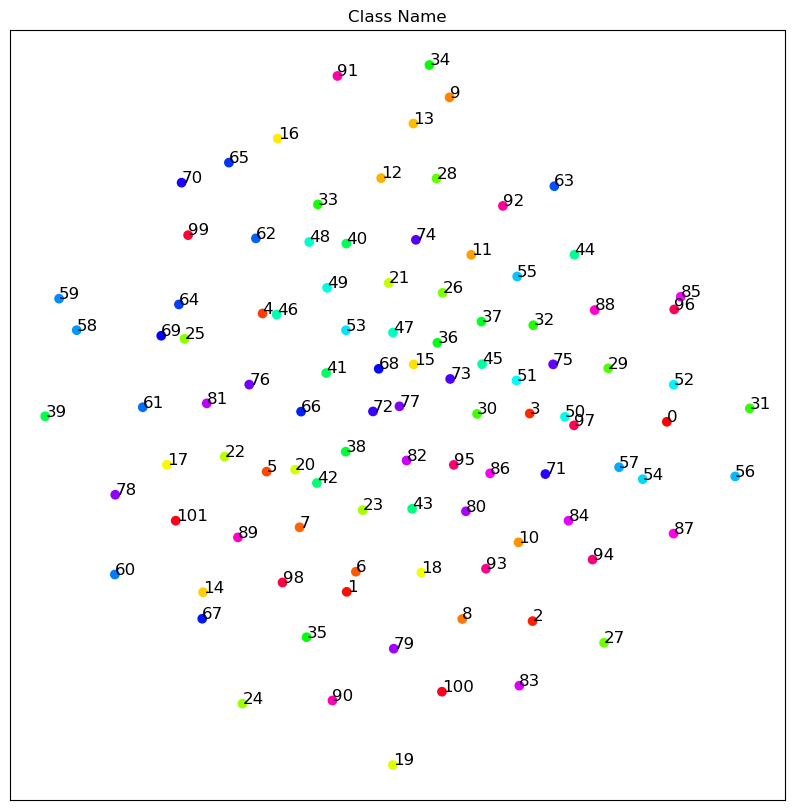

Rank 1: (4)english marigold - (46)marigold, Similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, Similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, Similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, Similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, Similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, Similarity: 0.8447265625


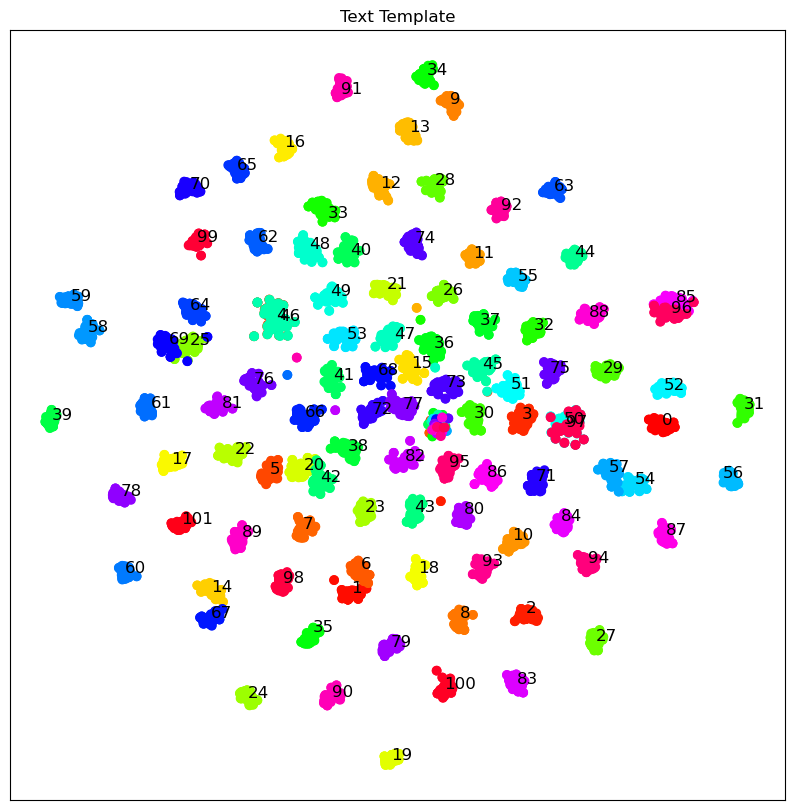

Rank 1: (4)english marigold - (46)marigold, Similarity: 0.97705078125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8935546875
Rank 7: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 8: (54)pelargonium - (57)geranium, Similarity: 0.8876953125
Rank 9: (20)fire lily - (42)sword lily, Similarity: 0.8818359375
Rank 10: (5)tiger lily - (20)fire lily, Similarity: 0.880859375


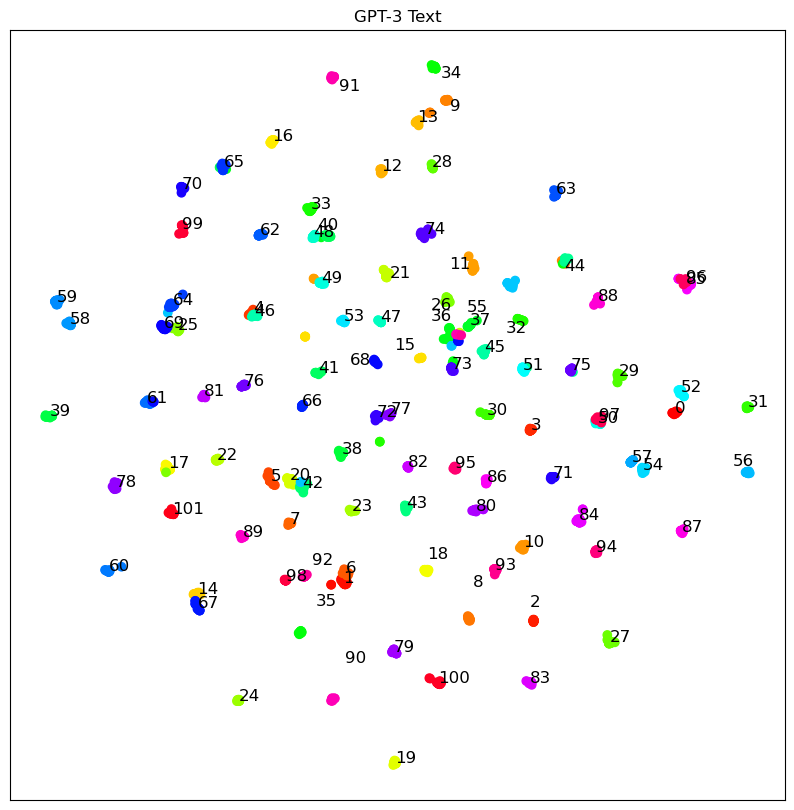

In [22]:
print_top_similarity(cls_name_similarity)
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], "Class Name")
print_top_similarity(template_similarity)
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], "Text Template")
print_top_similarity(gpt3_similarity)
plot_features_2d(transformed_features[gpt3_start_idx:gpt3_end_idx], all_label_ids[gpt3_start_idx:gpt3_end_idx], "GPT-3 Text")